In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image
import numpy as np

c:\Users\user\anaconda3\envs\summarizerP39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- sys settings ---

# square resolution image

#     image_res
#    _____|____
#   |         |
#    _________  __
#   |        |    |
#   |  image |    |-- image_res
#   |________|  __|
image_res = 32

#   how many classes to remember (types of images)

#               num classes
#    _______________|_______________
#   |                              |
#    ___   ___            ___   ___
#   |__|  |__|    ...    |__|  |__|
num_classes = 2

# --- net settings ---

# build parameters of the network

# network:
#               image_res^2 + num classes
#   (to represent: flattened image + which class to draw)
#           ________________|__________________
#          |                                  |
#          +  +  +  +  +   ...   +  +  +  +  +

#                      layer_size
#     ______________________|________________________           ___
#    |                                              |              |
#    +  +  +  +  +  +  +   ...   +  +  +  +  +  +  +               |
#                                                                  |
#                      layer_size                                  |
#     ______________________|________________________              |
#    |                                              |              |
#    +  +  +  +  +  +  +   ...   +  +  +  +  +  +  +               |
#                                                                  |
#                           .                                      |
#                           .                                      |____  num_hidden
#                           .                                      |
#                                                                  |
#                      layer_size                                  |
#     ______________________|________________________              |
#    |                                              |              |
#    +  +  +  +  +  +  +   ...   +  +  +  +  +  +  +               |
#                                                                  |
#                      layer_size                                  |
#     ______________________|________________________              |
#    |                                              |              |
#    +  +  +  +  +  +  +   ...   +  +  +  +  +  +  +             __|

#                            3
#       (to represent: RGB values per that pixel)
#                         ___|___
#                        |      |
#                        +  +  +

# on initialization weights and biases are randomly chosen for each neurone from:

# -init_range   <---------------------------0--------------------------->   +init_range

num_hidden = 3
layer_size = 2048
init_range = 0.3

# notes:

# i havent explored making different shaped networks (using diffenrent layer sizes for each layer) much,
# but i found that using a rectangle network works best.

# using an init range of 1 to -1 is probably leads to better results because the network starts off having less dull colors

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fcip = nn.Linear(image_res * image_res + num_classes, layer_size)
        
        for i in range(num_hidden):
            setattr(self, f'fc{i}', nn.Linear(layer_size, layer_size))
            nn.init.uniform_(getattr(self, f'fc{i}').weight, a=-init_range, b=init_range)

        self.fcop = nn.Linear(layer_size, 3)
        nn.init.uniform_(self.fcip.weight, a=-init_range, b=init_range)
        nn.init.uniform_(self.fcop.weight, a=-init_range, b=init_range)

    def forward(self, x):
        x = torch.tanh(self.fcip(x))
        
        for i in range(num_hidden):
            x = torch.tanh(getattr(self, f'fc{i}')(x))
        
        x = torch.sigmoid(self.fcop(x))
        return x

net = Net()
GPU = torch.device("cuda")
net.to(GPU)

Net(
  (fcip): Linear(in_features=1026, out_features=2048, bias=True)
  (fc0): Linear(in_features=2048, out_features=2048, bias=True)
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (fcop): Linear(in_features=2048, out_features=3, bias=True)
)

In [4]:
loss = nn.BCELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.000001)

In [5]:
def get_img_array(class_tensor):
    coords = torch.meshgrid(torch.arange(image_res * image_res, dtype=torch.long, device=GPU))
    
    coords = torch.stack(coords, dim=-1)
    
    encoded = F.one_hot(coords).squeeze(1)
    
    with_classes = torch.zeros((image_res * image_res, image_res * image_res + num_classes))
    with_classes = with_classes.to(GPU)
    
    with_classes[:, :-num_classes] = encoded
    with_classes[:, -num_classes:] = class_tensor.repeat(image_res * image_res, 1)
    
    return net(with_classes.to(torch.float32)).reshape(image_res, image_res, 3)

In [6]:
def load_image(image_path):
    img = Image.open(image_path)
    img = img.resize((image_res, image_res))
    img = img.convert("RGB")
    img_array = np.array(img) / 255

    return torch.tensor(img_array, dtype=torch.float32, device=GPU)

In [7]:
def display_image(img_array):
    if type(img_array) != type(np.array([1, 2, 3])):
        img_array = img_array.detach().cpu().numpy()
    plt.imshow(img_array)
    plt.show()

In [8]:
def train_nn(question_tensor, answer_tensor, model, loss=loss, optimizer=optimizer):
    optimizer.zero_grad()
    outputs = model(question_tensor)
    loss = loss(outputs, answer_tensor)
    loss.backward()
    optimizer.step()

In [9]:

files_class_1 = os.listdir(r"PATH TO FOLDER")
files_class_2 = os.listdir(r"PATH TO FOLDER")

tensor_class_1 = torch.tensor([1, 0], dtype=torch.float32, device=GPU)
tensor_class_2 = torch.tensor([0, 1], dtype=torch.float32, device=GPU)

questions = []
answers = []

for x in tqdm(range(len(files_class_1))):
    img_c1 = load_image(fr"PATH TO FOLDER\{files_class_1[x]}").reshape(image_res * image_res, 3)
    img_c2 = load_image(fr"PATH TO FOLDER\{files_class_2[x]}").reshape(image_res * image_res, 3)
    
    for y in range(len(img_c1)):
        encoded = torch.cat((torch.zeros(image_res * image_res, device=GPU), tensor_class_1))
        
        encoded[y] = 1
        
        questions.append(encoded)
        answers.append(img_c1[y])
        
        encoded = torch.cat((torch.zeros(image_res * image_res, device=GPU), tensor_class_2))
        
        encoded[y] = 1
        
        questions.append(encoded)
        answers.append(img_c2[y])
        
        encoded = torch.cat((torch.zeros(image_res * image_res, device=GPU), tensor_class_1 + tensor_class_2))
        
        encoded[y] = 1
        
        questions.append(encoded)
        answers.append((img_c1[y] + img_c2[y]))

100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


In [10]:
for y in tqdm(range(3)):
    for x in (range(len(questions))):
        train_nn(questions[x], answers[x], net)

100%|██████████| 3/3 [09:51<00:00, 197.17s/it]


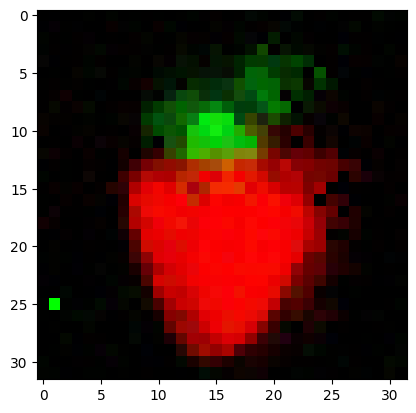

In [16]:
# strawberry:

display_image(get_img_array(torch.tensor([1, 0],device=GPU)))

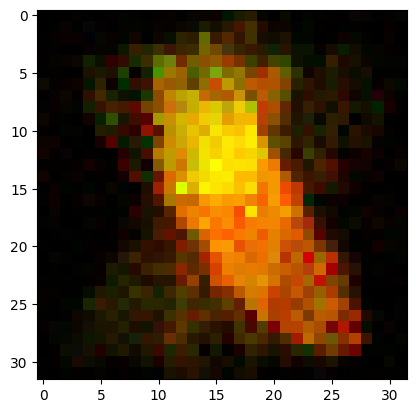

In [19]:
# banana:

display_image(get_img_array(torch.tensor([0, 1],device=GPU)))

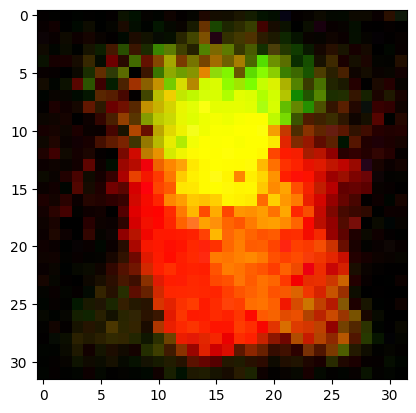

In [18]:
# both of them:

display_image(get_img_array(torch.tensor([1, 1],device=GPU)))

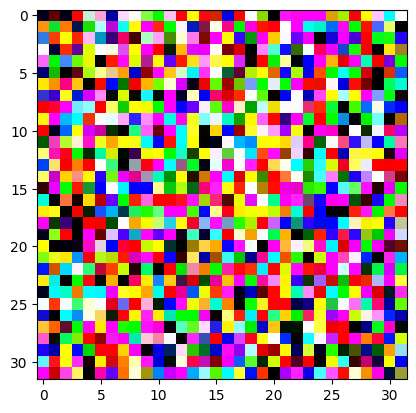

In [28]:
# all zeros:

display_image(get_img_array(torch.tensor([0, 0],device=GPU)))

In [26]:
# good parameters i found:
# image_res = 32
# num_hidden = 3
# layer_size = 2048
# init_range = 0.3
# loss = nn.BCELoss()
# optimizer = optim.AdamW(net.parameters(), lr=0.000001)
# train over a few epochs (~3)